In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
# import autokeras as ak
import corner
import os 
import sys
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
%%time
training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v1.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

target = np.column_stack([training_data["theta23"], training_data["delta"]/180*np.pi])

x_train = data_all[:90]
y_train = target[:90]
y_train_angle = np.column_stack([y_train[:,0], np.sin(y_train[:,1]), np.cos(y_train[:,1])]) 

# x_test = data_all[9000000:]
# y_test = target[9000000:]
# y_test_angle = np.column_stack([y_test[:,0], np.sin(y_test[:,1]), np.cos(y_test[:,1])]) 

x_train_poisson = np.random.poisson(x_train)/1000
# x_test_poisson = np.random.poisson(x_test)/1000

CPU times: user 20.3 s, sys: 5.05 s, total: 25.4 s
Wall time: 25.4 s


In [3]:
path = './CVAE/DNN_angleTran_20g_{}'.format(1)
guassian_number = 20
encoder1 = load_model(path + "/encoder_1_test_v2.h5", compile=False)
encoder2 = load_model(path + "/encoder_2_test_v2.h5", compile=False)
decoder = load_model(path + "/decoder_test_v2.h5", compile=False)

In [4]:
%%time
n = 1
data_poisson_array = x_train[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, guassian_number, 7))
log_var = tf.reshape(log_var, (-1, guassian_number, 7))
weight = tf.reshape(weight, (-1, guassian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 1000000
prediction = []

Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, 7))
target_array = np.reshape([data_poisson_array for i in range(sample_amount)], (sample_amount, 144))
reconstruction_mean, reconstruction_var = decoder.predict([Z3, target_array])
temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                         loc=reconstruction_mean,
                         scale_diag= tf.sqrt(temp_var))
prediction = reconstruction_parameter.sample().numpy()

prediction = np.array(prediction)
logging.info(prediction.shape)

CPU times: user 49.2 s, sys: 6.5 s, total: 55.7 s
Wall time: 35.5 s


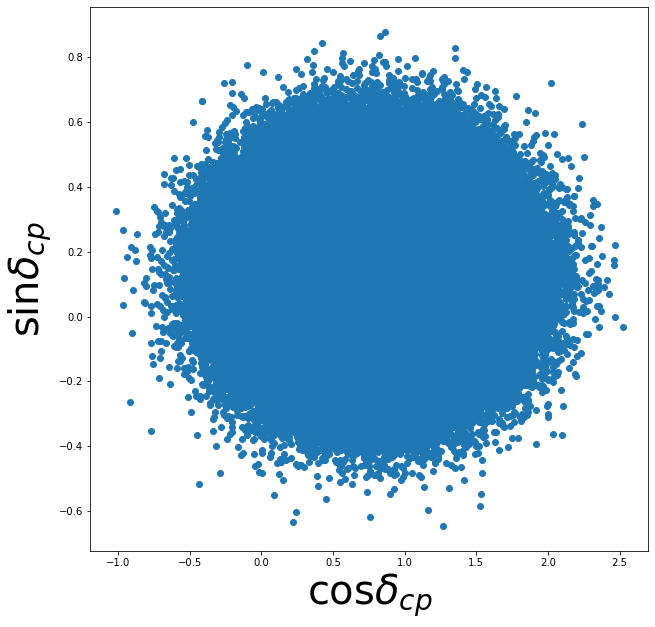

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(prediction[:, 2], prediction[:, 1])
plt.xlabel('cos$\delta_{cp}$', fontsize = 40)
plt.ylabel('sin$\delta_{cp}$', fontsize = 40)
plt.savefig('tmp')
plt.show()

In [6]:
degree = np.angle(prediction[:,2] + 1j*np.array(prediction[:,1]), deg=True)
degree = [d if d > 0 else 360+d for d in degree]
prediction2 = np.column_stack([prediction[:,0], degree])

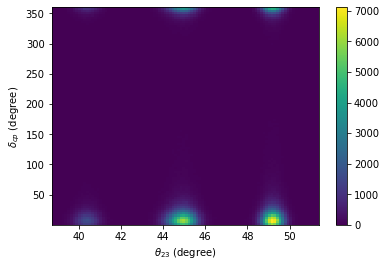

In [7]:
plt.hist2d(prediction2[:,0], prediction2[:,1], bins = 100)
plt.xlabel('$\\theta_{23}$ (degree)')
plt.ylabel('$\delta_{cp}$ (degree)')
plt.colorbar()
plt.savefig('tmp')
plt.show()

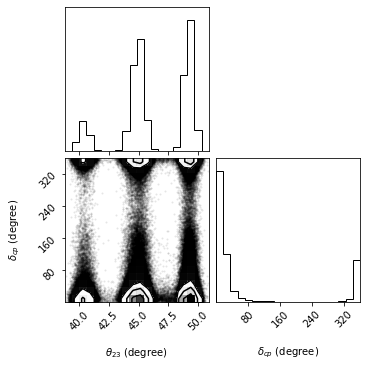

In [15]:
figure = corner.corner(prediction2, labels=["$\\theta_{23}$ (degree)", "$\delta_{cp}$ (degree)"])